# Progetto Data Intensive

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Riccardo Romagnoli `832198`  
`riccardo.romagnoli3@studio.unibo.it`

## Introduzione
In questo progetto analizzeremo un caso di studio che mi riguarda personalmente nella mia attività di venditore terzo in Amazon. 

L'obbiettivo consiste nel ricercare un modello predittivo di vendite di un determinato prodotto. Questa informazione verrà poi utilizzata per stimare la durata residua dell'inventario attualmente disponibile in magazzino, quindi sapere in quanti giorni il prodotto andrà **out of stock** così da organizzare eventuali rifornimenti.

Amazon fornisce ai venditori dei dati separati per **marketplace** (Amazon IT, Amazon ES ...), per questo progetto condidereremo solo i dati relativi al marcato Spagnolo poichè unirli non porterebbe un aumento di valore consistente. Inoltre l'unione delle due sorgenti dati potrebbe far perdere caratteristiche differenti per il paese di provenienza.

## 1 - Panoramica
Scaricato il documento dal sito riservato dei venditori amazon ci troviamo con *BusinessReport-ES.csv* da cui potremo iniziare ad eseguire operazioni di pulizia di istanze e drop di colonne non rilevanti.

### Setup
- Importare i package necessari per il progetto in questione

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

- In Jupyter, configurare l'output di matplotlib integrato nel notebook

In [2]:
%matplotlib inline

- Disabilito i warning

In [3]:
import warnings
warnings.filterwarnings('ignore')

- Classe colori print

In [4]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

Lettura dei due file utilizzando `read_csv` impostando come indice la data e come etichette la prima riga (default).

In [5]:
Vendite = pd.read_csv("BusinessReport-ES.csv", index_col="Data", parse_dates=["Data"], sep=";")

In [6]:
Vendite.tail()

,Vendite prodotti ordinati,Vendite di prodotti ordinati - B2B,Totale prodotti ordinati,Tot. articoli ordinati - B2B,Prezzo medio di vendita,Prezzo medio di vendita - B2B,Visualizzazioni pagina,Sessioni,Percentuale Buy Box,Conteggio medio delle offerte
Data,,,,,,,,,,
2020-05-23,"143,32 €","0,00 €",7,0,"21,24 €","21,24 €",148,85,80%,6
2020-05-24,"210,04 €","0,00 €",10,0,"21,24 €","21,24 €",142,85,100%,6
2020-05-25,"84,05 €","0,00 €",4,0,"21,24 €","21,24 €",86,44,89%,6
2020-05-26,"89,47 €","0,00 €",4,0,"21,24 €","21,24 €",91,34,100%,5
2020-05-27,"93,87 €","0,00 €",4,0,"21,24 €","21,24 €",87,45,99%,6


### Dati Disponibili

- `Vendite prodotti ordinati`: Tot fatturato dalle vendite
- `Vendite di prodotti ordinati - B2B`: Tot fatturato dalle vendite B2B
- `Totale prodotti ordinati`: Totale dei prodotti ordinati 
- `Tot. articoli ordinati - B2B`: Totale dei prodotti ordinati B2B
- `Prezzo medio di vendita`: Media dei prezzi dei prodotti venduti
- `Prezzo medio di vendita - B2B`: Media dei prezzi dei prodotti venduti B2B
- `Visualizzazioni pagina	`: Comparizioni nei risultati di ricerca
- `Sessioni`: Per sessione s'intende la visita da parte di un utente alle pagine Amazon del venditore. Qualsiasi attività effettuata entro un periodo di tempo di 24 ore è considerata come una unica sessione.
- `Percentuale Buy Box`: Si tratta della percentuale di visualizzazioni di pagine in cui compare la Buy Box (link "Aggiungi al carrello") e che consente ai clienti di aggiungere il prodotto al carrello.
- `Conteggio medio delle offerte`: Si tratta di una metrica di conversione percentuale indicante la quantità di unità acquistate relativamente al numero di persone che hanno visualizzato i prodotti. (Impreciso, spesso a 0 quando invece vengono generate vendite)

Da una prima analisi possiamo subito decidere di unificare i dati relativi al B2B poichè le restanti feature sono influenzate anche da visitatori *Business*. Quindi non eseguire questa operazione ci farebbe mantenere, per esempio, delle sessioni e visualizzazioni che si sono convertite in vendite di cui però non teniamo traccia.

Possiamo eliminare le colonne che fanno riferimento al fatturato giornaliero poichè non rilevante, come anche il prezzo medio delle vendite B2B poichè duplicato in `Prezzo medio di vendita`.

In [7]:
Vendite["Vendite prodotti ordinati"] = Vendite.loc[:,["Vendite prodotti ordinati",
                                                      "Vendite di prodotti ordinati - B2B"]].sum(axis=1)

Vendite.drop(columns=[
    "Vendite prodotti ordinati", 
    "Vendite di prodotti ordinati - B2B", 
    "Tot. articoli ordinati - B2B", 
    "Prezzo medio di vendita - B2B",
    ], inplace=True);

Ora, analizzando il tipo dei dati delle colonne dei nostri DF constatiamo che è errato a causa del simbolo dell'euro, delle percentuali e le virgole. Proseguiamo trasformando questi dati in tipo float dopo aver correttamente sostituito i caratteri problematici.

In [8]:
Vendite.dtypes

Totale prodotti ordinati          int64
Prezzo medio di vendita          object
Visualizzazioni pagina            int64
Sessioni                          int64
Percentuale Buy Box              object
Conteggio medio delle offerte     int64
dtype: object

In [9]:
Vendite["Prezzo medio di vendita"] = Vendite["Prezzo medio di vendita"].replace({'\€': '', ',': '.'}, regex=True).astype(float)
Vendite["Percentuale Buy Box"] = Vendite["Percentuale Buy Box"].replace({'\%': '', ',': '.'}, regex=True).astype(float)

In [10]:
Vendite.dtypes

Totale prodotti ordinati           int64
Prezzo medio di vendita          float64
Visualizzazioni pagina             int64
Sessioni                           int64
Percentuale Buy Box              float64
Conteggio medio delle offerte      int64
dtype: object

In [11]:
#Rinominazione colonne
Vendite.columns = ['ordini','prezzo_medio','visualizzazioni','sessioni','per_buybox','offerte_attive']

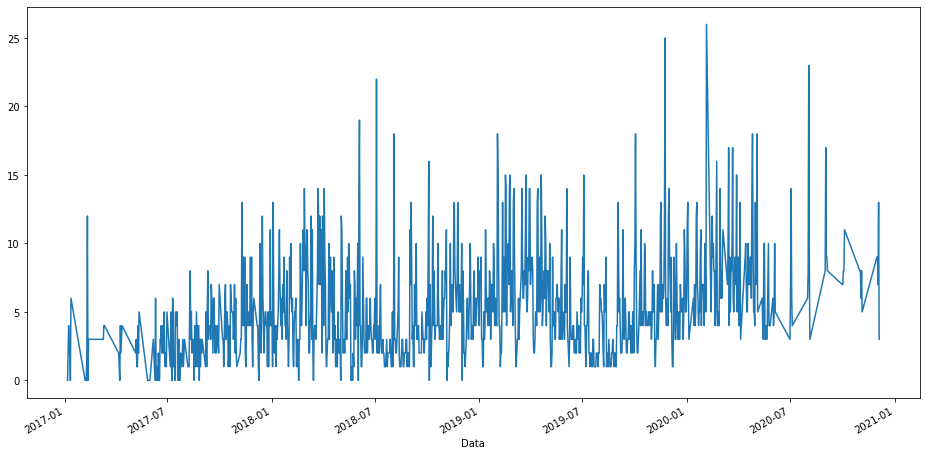

In [12]:
Vendite["ordini"].plot(figsize=(16, 8));

A questo punto è necessario specificare più nel dettaglio di che tipo di prodotto stiamo parlando e a cosa si riferisce ogni riga. Il propdotto in questione ha la caratteristica di essere suddiviso in taglie (S M L XL ...) e quindi una taglia potrebbe essere *out-of-stock*, non generando vendite e allo stesso tempo generando volume di dati raccolti (**ES: visualizzo la pagina ma non posso comprare perchè la taglia non è disponibile**). In ogni instanza abbiamo i dati totali generati da tutte le taglie.

Quindi il Prossimo filtro applicato rimuoverà le righe con offerte attive < 3 e vendite < 2. Questo perchè questi giorni molto probabilmente sono influenzati dalla disponibilità in magazzino del prodotto. Un'altra accortezza di correzzione dei dati sta nel correggere il valore offerte_attive = 0 quando in realta sono presenti delle vendite per quei giorni. (Purtroppo questo errore è attribuibile a calcoli errati di Amazon).

In [13]:
#Rimozione Istanze "Critiche"
to_remove = ((Vendite["offerte_attive"] < 3) & (Vendite["ordini"] < 2))
Vendite.drop(Vendite[to_remove].index, inplace=True)

#Assegnamento valore medio di offerte medie attive quando è queste sono 0 e in realtà ci sono vendite registrate
Vendite.loc[(Vendite["offerte_attive"] == 0) & (Vendite["ordini"] > 0),
            "offerte_attive"] = Vendite["offerte_attive"].mean()

### A - Il problema

Finita la fase di preparazione dei dati possiamo proseguire analizzando più nel dettaglio il nostro dataset facendo tutte le considerazioni del caso.

Come anticipato, il seguente progetto si pone come obbiettivo finale la stima dei giorni di inventario rimanendi sulla base di una quantità attuale di prodotti in magazzino. Questo è possibile predicendo le vendite giornaliere (variabile discreta) dei giorni a seguire stimando le possibili visualizzazioni che l'annuncio puo avere sulla base del trend settimanale e stagionale.

Le feature principali, e quindi le possibili variabili predittive, sono:

- `Prezzo medio di vendita`: Media dei prezzi dei prodotti venduti
- `Visualizzazioni pagina`: Comparizioni nei risultati di ricerca
- `Sessioni`: Per sessione s'intende la visita da parte di un utente alle pagine Amazon del venditore. Qualsiasi attività effettuata entro un periodo di tempo di 24 ore è considerata come una unica sessione.
- `Percentuale Buy Box`: Si tratta della percentuale di visualizzazioni di pagine in cui compare la Buy Box (link "Aggiungi al carrello") e che consente ai clienti di aggiungere il prodotto al carrello.
- `Conteggio medio delle offerte`: Il numero medio di offerte in vendita, nell'intervallo tempo. Il calcolo si basa sul numero totale di offerte e il numero totale di giorni nell'intervallo di tempo (1 giorno). 

Per quanto riguarda il numeo di istanza, attualmente si hanno dati rilevanti per 1080 giorni, quasi tre anni solare, che dovranno poi essere suddivisi in set di Training, Validation e Test. Questi spaziano da maggio 2017 a maggio 2020

In [14]:
len(Vendite)

1080

### B - Analisi esplorativa

Iniziamo ottenendo le statistiche generali sulle variabili sopra commentate

In [15]:
Vendite.describe()

,ordini,prezzo_medio,visualizzazioni,sessioni,per_buybox,offerte_attive
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,5.210185,21.797769,94.873148,58.720370,72.525000,5.794756
std,3.608415,3.674146,58.868459,36.294077,20.380153,0.937160
min,0.000000,0.000000,7.000000,6.000000,8.000000,1.000000
25%,3.000000,21.240000,53.750000,34.000000,57.000000,6.000000
50%,4.000000,21.240000,83.000000,52.500000,72.000000,6.000000
75%,7.000000,23.240000,121.000000,73.000000,91.000000,6.000000
max,26.000000,31.990000,309.000000,201.000000,100.000000,7.000000


Con le giuste supposizioni possiamo identificale la feature `visualizzazioni` inclusa nelle `sessioni` poichè quest'ultima ne è un sotto insieme. Intuitamente, la sola comparsa nei risultati di ricerca non apporta un valore aggiuntivo della gia presente `sessione` che identifica la visita della pagina del prodotto, da dove si può finalizzare l'acquisto.

Nei dati sopra descritti si evinche che gli ordini non assumono un range di valori molto sparsi, consideranzo il primo quartile di 3 ordini e il terzo quartile di 7 ordini.

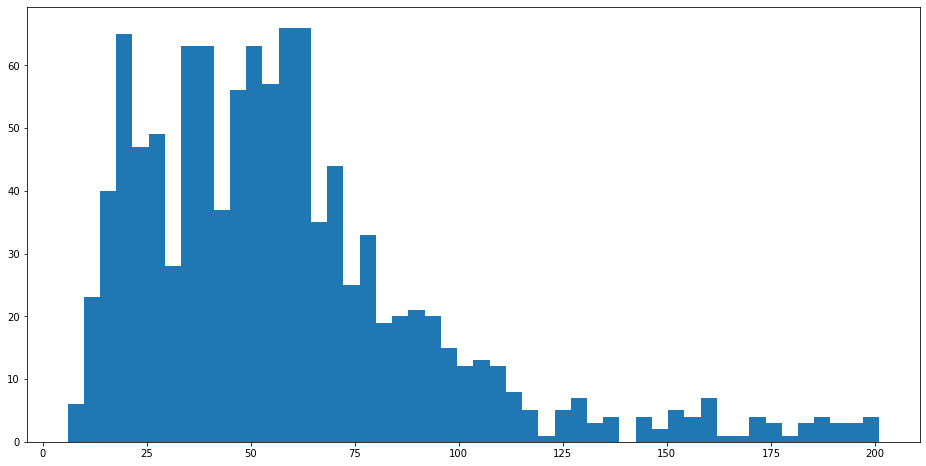

In [16]:
plt.figure(figsize=(16,8)) #change your figure size
plt.hist(Vendite["sessioni"], bins= 50);

Aggiungiamo la colonna giorno della settimana per ordinare i grafici box

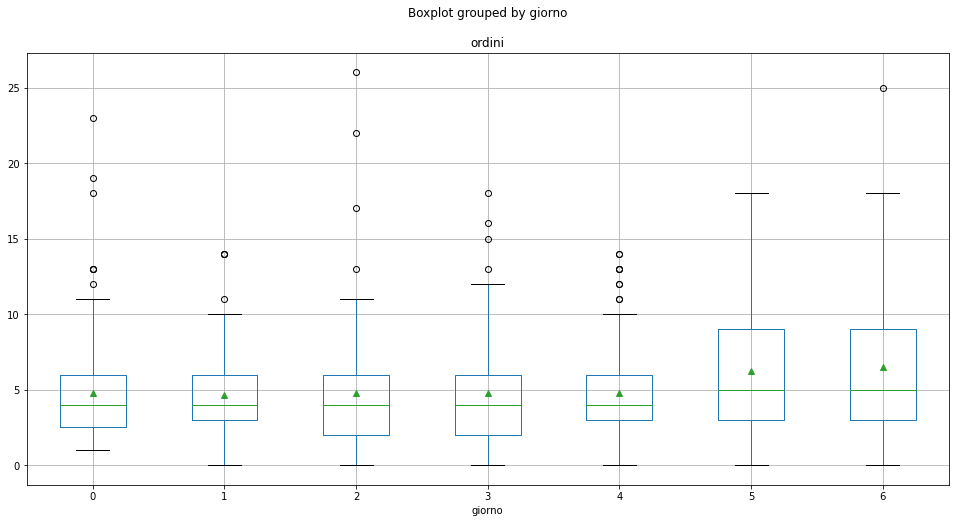

In [17]:
Vendite.loc[:,"giorno"] = Vendite.index.dayofweek
columns_my_order = ['Monday', 'Tusday', 'Wednesday', 'Thursday', "Friday", "Saturday", "Sunday"]

Vendite.boxplot(column="ordini", by="giorno", showmeans=True, figsize=(16, 8));


Osservando il grafico si evince che nonostanze durante i giorni intermedi della settimana si verifichino più valori outlier, i weekend sono i giorni che registrano più vendite. 

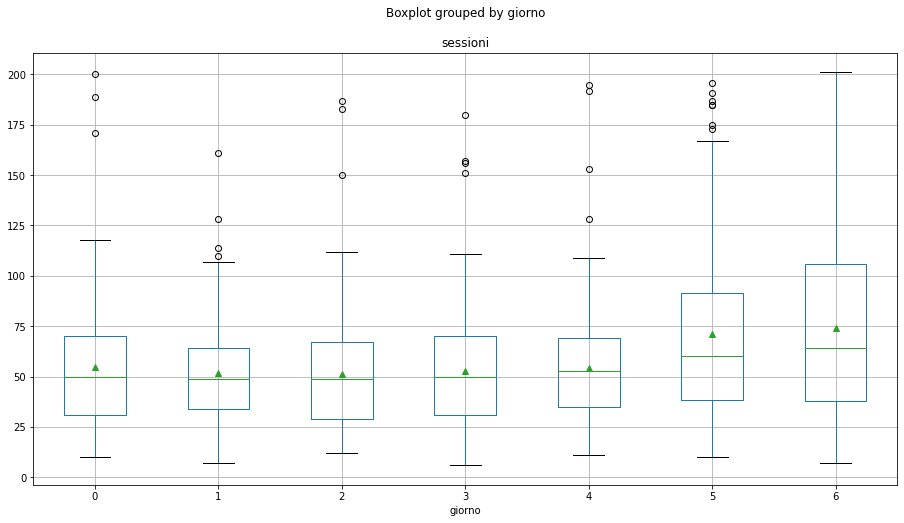

In [18]:
Vendite.boxplot(column="sessioni", by="giorno", showmeans=True, figsize=(15, 8));

Come poteva essere prevedibile, anche i dati relativi alle sessioni sono più marcati durante i weekend.

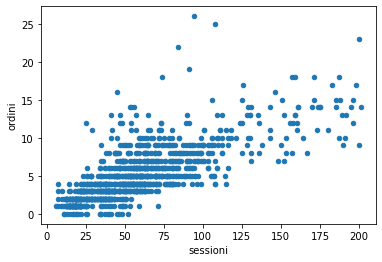

In [19]:
Vendite.plot.scatter("sessioni","ordini");

- Il grafico evidenzia che tendenzialmente gli ordini (come prevedibile) sono tanto più alti quanto lo sono le sessioni.

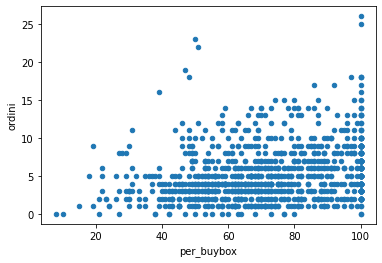

In [20]:
Vendite.plot.scatter("per_buybox","ordini");

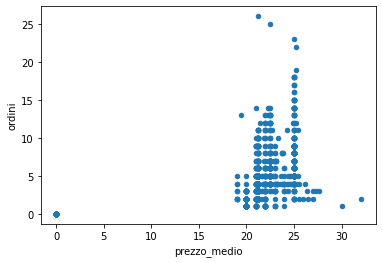

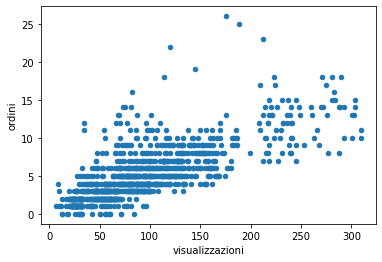

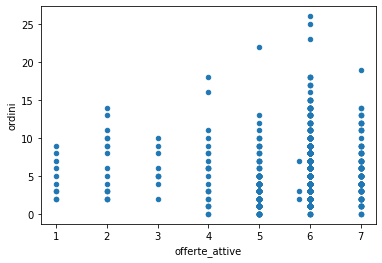

In [21]:
Vendite.plot.scatter("prezzo_medio","ordini");
Vendite.plot.scatter("visualizzazioni","ordini");
Vendite.plot.scatter("offerte_attive","ordini");

In [22]:
#Correlazione di Pearson
corr = pd.DataFrame(columns=["ordini"], 
             index=Vendite.columns)
corr.drop(["ordini", "giorno"], inplace=True)
for r in corr.index:
    corr.loc[r, :] = np.corrcoef(Vendite["ordini"], Vendite[r])[0, 1]
corr

,ordini
prezzo_medio,0.407855
visualizzazioni,0.747777
sessioni,0.748732
per_buybox,0.258814
offerte_attive,0.0474824


- Il _coefficiente di correlazione di Pearson è un indice usato per valutare numericamente il grado di correlazione tra due variabili X e Y
- Il suo valore è compreso tra -1 e 1
  - valori vicini a 1 indicano correlazione diretta (Y cresce al crescere di X)
  - valori vicini a -1 indicano correlazione inversa (Y descresce al crescere di X)
  - valori vicini a 0 indicano assenza di correlazione
- Date due variabili casuali $X$ e $Y$, il coefficiente è il rapporto tra la loro covarianza $\sigma_{XY}$ e il prodotto delle deviazioni standard $\sigma_X$ e $\sigma_Y$
$$ \rho(X,Y) = \frac{\sigma_{XY}}{\sigma_X\sigma_Y} $$

Usiamo la funzione di numpy per più immediatezza e pulizia di calcolo e scopriamo che come i grafici suggerivano le visualizzazioni e le sessioni sono i dati più correlati con gli ordini. Il numero di offerte attive ha una correlazione di quasi 0, cioè assente. Possiamo identificare una certa correlazione con il prezzo_medio e la % di buy box

In [23]:
features = {"sessioni": Vendite["sessioni"], 
            "visualizzazioni": Vendite["visualizzazioni"], 
            "prezzo_medio": Vendite["prezzo_medio"], 
            "per_buybox": Vendite["per_buybox"], 
            "offerte_attive": Vendite["offerte_attive"], }

## 2 - Elaborazione Features

Procediamo con l'importazione di moduli sklearn, definizione di funzioni utili in questa sezione e le successive e la separazione del set in traning e validation.

In [24]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge                  #Regolarizzazione L2
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

In [25]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [26]:
def print_eval(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

In [27]:
def plot_model_on_data(X, y, model=None):
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Sessioni"); plt.ylabel("Ordini")

In [28]:
def split_before(X, y, date):
    is_train = X.index < date
    X_train = X.loc[is_train]
    y_train = y.loc[is_train]
    X_val = X.loc[~is_train]
    y_val = y.loc[~is_train]
    return X_train, X_val, y_train, y_val

In [29]:
# Create a function called lasso,
def lasso(X, y, alphas):
    '''
    Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    # Create an empty data frame
    df = pd.DataFrame()
    
    # Create a column of feature names
    df['Feature Name'] = X.columns
    
    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        lasso = Lasso(alpha=alpha)
        
        # Fit the lasso regression
        lasso.fit(X, y)
        
        # Create a column name for that alpha value
        column_name = 'Alpha %f' % alpha

        # Create a column of coefficient values
        df[column_name] = lasso.coef_
        
    # Return the datafram    
    return df

In [30]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt((a1 * (1 - a1) / N1) + (a2 * (1 - a2) / N2))
    return d - Z * sd, d + Z * sd

In [31]:
# Se l'intervallo ottenuto non include lo zero (l'estremo inferiore è positivo), 
# abbiamo la certezza al 95% (o altro livello di confidenza) che il modello con 
# accuratezza stimata maggiore sia effettivamente migliore

def model_diff_interval(m1, m2, X, y, X1=0, y1=0, P=0.95, same=True):
    if(same):
        X1 = X
        y1 = y
    a1 = m1.score(X, y)
    a2 = m2.score(X1, y1)
    N = len(X)
    Z = norm.ppf((1 + P) / 2)
    return diff_interval(a1, a2, N, N, Z)

In [32]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [33]:
def model_conf_interval(model, X, y, level=0.95):
    a = model.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

### Divisione tra training e validation set

Per verificare se un modello generalizza correttamente i dati su cui è addestrato, è importante **validarlo su dati diversi**.
Il metodo _hold-out_ prevede di dividere i dati a disposizione in
  - un _training set_ su cui addestrare il modello
  - un _validation set_ su cui calcolare le metriche di accuratezza del modello addestrato
La proporzione tra training e validation set è arbitraria, possono essere ad es. 50-50 e 66-33, noi faremo riferimento a quest'ultimo esempio di suddivizione

In [34]:
y = Vendite["ordini"]
X = pd.DataFrame(features)

In [35]:
X_train, X_val, y_train, y_val = split_before(X, y, "2019-05-27")

In [36]:
print("train set: \t", X_train.shape[0] / X.shape[0])
print("val set: \t", X_val.shape[0] / X.shape[0])

train set: 	 0.6601851851851852
val set: 	 0.3398148148148148


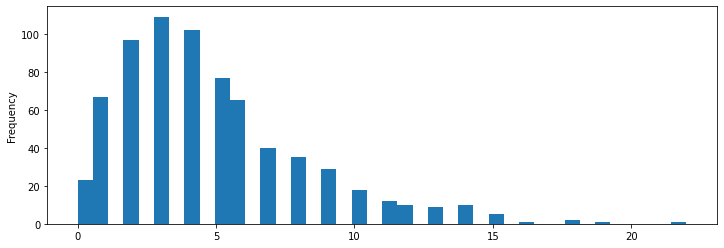

In [37]:
y_train.plot.hist(bins=40, figsize=(12, 4));

### Confronto con un modello casuale

- Per avere una valutazione più completa dei modelli che andremo ad ottenere, possiamo metterli a confronto con quello che accadrebbe prendendo decisioni casuali
- Consideriamo un modello che predica dei valori $\hat{\Delta}_d$ casuali, ma con la stessa distribuzione dei valori $\Delta_d$ reali
- Disegnando un istogramma, vediamo che $\Delta_d$ ha una distribuzione quasi normale, riusciamo a replicare una distribuzione simile invertendo i valori negativi e facendo dei tentativi di seed.

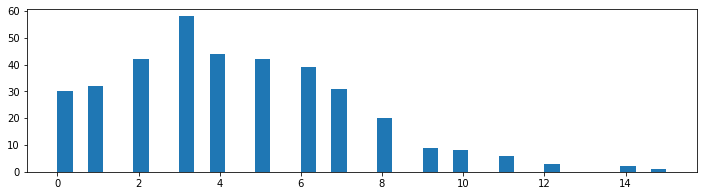

In [38]:
np.random.seed(5555415)
random_preds = np.random.normal(
    y_train.mean(),     # centro (media)
    y_train.std(),    # scala (dev. standard)
    len(y_val)          # numero di campioni
)
random_preds = pd.array(list(map(lambda i: -i if(i < 0) else i, random_preds)))
plt.figure(figsize=(12, 3))
plt.hist(random_preds.astype(int), bins=40);

In [39]:
def test_random(X, y, model, P=0.99):
    preds = model.predict(X)
    a1 = model.score(X, y)
    a2 = r2_score(y, random_preds)
    N = len(X)
    Z = norm.ppf((1 + P) / 2)
    print("MODEL    Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("MODEL        Relative error: {:.5%}".format(relative_error(y, preds)))
    print("MODEL R-squared coefficient: {:.5}".format(r2_score(y, preds)))
    print("")
    print("RANDOM   Mean squared error: {:.5}".format(mean_squared_error(y, random_preds)))
    print("RANDOM       Relative error: {:.5%}".format(relative_error(y, random_preds)))
    print("RANDOM R-squared coefficient: {:.5}".format(a2))
    print("")
    # Non possiamo utilizzare l'intervallo di confidenza
    #print("CONFIDENZA MODELLO RANDOM 99%: ", diff_interval(a1, a2, N, N, Z))

Nella definizione della funzione, che verrà utilizzata per confrontare i modelli con una modello di generazione random, non è stato possibile utilizzare l'intervallo di confidenza con la metrica r^2 delle predizini random. Questo perchè il calcolo del parametro di confidenza si basa sulla risoluzione di una radice quadrata che con un parametro di accuratezza r^2 arbitrariamente negativo (modello random) diventa di risoluzione impossibile (entra nello spazio dei numeri immaginari).

Per questo motivo faremo riferimento alle sole metriche MSE, RE e R^2.

Utilizzeremo invece il confronto degli intervalli di confidenza al momento della selezione dei modelli migliori.

### Lasso

Di seguito notiamo la rilevanza di ogni feature con la regressione lasso. Osserviamo come aumentando il valore dei `alpha` le feature che vengono escluse prima sono `offerte_attive` e `prezzo_medio` nonostante entrambe mostrassero una correlazione di Pearson maggiore di 0.4. La `per_buybox` invece, che mostrava una correlazione minore, sembra avere una modesta rilevanza.

In [40]:
lasso(X, y, np.linspace(0.001, 3, 10))

,Feature Name,Alpha 0.001000,Alpha 0.334222,Alpha 0.667444,Alpha 1.000667,Alpha 1.333889,Alpha 1.667111,Alpha 2.000333,Alpha 2.333556,Alpha 2.666778,Alpha 3.000000
0,sessioni,0.051118,0.049280,0.048544,0.047803,0.047070,0.046343,0.045208,0.044025,0.042838,0.041655
1,visualizzazioni,0.011726,0.013173,0.014179,0.015187,0.016190,0.017191,0.017889,0.018548,0.019209,0.019868
2,prezzo_medio,0.137693,0.112930,0.085462,0.057994,0.030525,0.003054,0.000000,0.000000,0.000000,0.000000
3,per_buybox,0.028447,0.026441,0.025612,0.024783,0.023956,0.023130,0.022094,0.021031,0.019968,0.018905
4,offerte_attive,-0.157141,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000


In [41]:
y_ses = Vendite["ordini"]
X_ses = pd.DataFrame(features["sessioni"])
X_ses_train, X_ses_val, y_ses_train, y_ses_val = split_before(X_ses, y_ses, "2019-05-27")

y_some = Vendite["ordini"]
X_some = pd.DataFrame(features).loc[:, ["sessioni", "visualizzazioni", "per_buybox"]]
X_some_train, X_some_val, y_some_train, y_some_val = split_before(X_some, y_some, "2019-05-27")

### Standardizzazione

Durante il preprocessing risulta utile utilizzare lo `StandardScalare` per mantenere la stessa distribuzione dei dati ma con media 0 e deviazione standard 1. Nell'esempio successivo viene mostrato come la standardizzazione dei dati è essenziale quando vendono utilizzate delle feature polinominali di grado elevato. Per un primo momento utilizziamo la sola feature `sessioni`

In [42]:
lnrstd1 = Pipeline([
    ("poly",   PolynomialFeatures(degree=20, include_bias=False)),
    #("scale",  StandardScaler()),   # <--
    ("linreg", LinearRegression())
])
lnrstd1.fit(X_ses_train, y_ses_train)
print_eval(X_ses_val, y_ses_val, lnrstd1)

   Mean squared error: 23.016
       Relative error: 60.52542%
R-squared coefficient: -0.5323


MODEL    Mean squared error: 18.537
MODEL        Relative error: 34.82648%
MODEL R-squared coefficient: -0.2341

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453



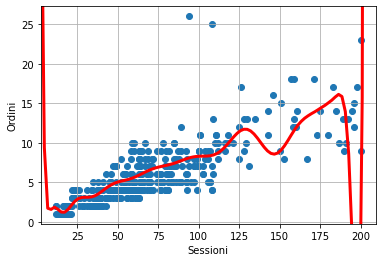

In [43]:
lnrstd2 = Pipeline([
    ("poly",   PolynomialFeatures(degree=20, include_bias=False)),
    ("scale",  StandardScaler()),   # <--
    ("linreg", LinearRegression())
])
lnrstd2.fit(X_ses_train, y_ses_train)
test_random(X_ses_val, y_ses_val, lnrstd2)
plot_model_on_data(X_ses_val, y_ses_val, lnrstd2)

In questo ultimo modello, l'over-fitting agli estremi e a 3/4 del grafico puo essere risolto con una regressione Ridge. Proseguiamo confrontando modelli generati con e senza feature risultate poco rilevanti dalla regressione lasso.

In [44]:
some1 = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
some1.fit(X_some_train, y_some_train)
print_eval(X_some_val, y_some_val, some1)

   Mean squared error: 3.156
       Relative error: 25.47884%
R-squared coefficient: 0.78988


In [45]:
all1 = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
all1.fit(X_train, y_train)
print_eval(X_val, y_val, all1)

   Mean squared error: 3.1198
       Relative error: 24.44845%
R-squared coefficient: 0.7923


   Mean squared error: 5.4413
       Relative error: 34.18079%
R-squared coefficient: 0.63774


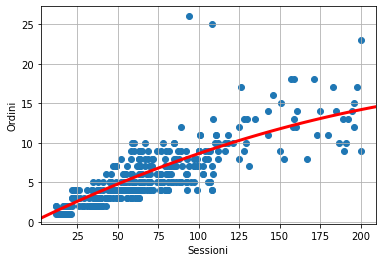

In [46]:
only1 = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
only1.fit(X_ses_train, y_ses_train)
print_eval(X_ses_val, y_ses_val, only1)
plot_model_on_data(X_ses_val, y_ses_val, only1)

In [47]:
model_diff_interval(
    all1, 
    some1, 
    X_val, 
    y_val, 
    X1=X_some_val, 
    y1= y_val, 
    same=False 
)

(-0.05640414680292054, 0.06123482818592156)

In [48]:
model_diff_interval(
    all1, 
    only1, 
    X_val, 
    y_val, 
    X1=X_ses_val, 
    y1= y_ses_val, 
    same=False 
)

(0.09021170331991177, 0.2189086628868914)

La comparazione dei primi due modelli `all1` `some1`, con esclusione delle 2 feature che la reg. lasso ha mostrato poco rilevanti, evidenzia che i rispettivi intervalli di confidenza non sono sufficientemente diversi per definirne uno migliore dell'altro.

Nell'ultimo esempio inceve, comparando `only1` con `all1` la metrica R^2 di quest'ultimo puo essere considerata migliore nei rispettivi intervalli di confidenza. Anche considerando le altre due metrice, `all1` produce risultati migliori. Questo sta a significare che prendere in considerazione altre feature oltre alla sola feature `sessioni`, che apparentemente è quella con più correlazione alla X, migliora il modello. Nel prossimo capitolo genereremo modelli più sofisticati che potenzialmente mostreranno in modo più marcato le differenze tra essi.

## 3 - Generazione Modelli
In questo capitolo:
- Creazione di modelli di apprendimento con tutti gli algoritmi visti a lezione
- Uso di random search, grid search, cross fold e nested cross fold
- Primi confronti tra modelli, calcolo metriche

Dalle analisi precedenti, partiamo dal presupposto di utilizzare l'intero set di features.

In [49]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.kernel_ridge import KernelRidge


kf = KFold(5, shuffle=True, random_state=43)
tss = TimeSeriesSplit(3)

Definiamo una funzione che ci calcoli la nested-cross-val 

In [50]:
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)
def nested_cv(model, grid, X, y):
    results = []
    bestscore = -1
    for train_indices, val_indices in outer_cv.split(X, y):
        gs = GridSearchCV(model, grid, cv=inner_cv);
        gs.fit(X.iloc[train_indices], y.iloc[train_indices]);
        score = gs.score(X.iloc[val_indices], y.iloc[val_indices]);
        if(score > bestscore):
            bestscore = score
            bestmodel = gs
        results.append({score : gs.best_params_})
    return results, bestmodel

### Validazione k-fold per serie temporali

Nella cross validation a _k_ fold ordinaria, i dati vengono divisi in _k_ fold mescolati casualmente, nel caso come questo di una serie temporale, vogliamo però mantenere l'ordine temporale in training e validation set. Utilizzeremo `TimeSeriesSplit(k)`. Faremo comunque dei tentadivi con dei fold classici.

In [51]:
for i, (train, val) in enumerate(tss.split(X), start=1):
    print("FOLD {}".format(i))
    train_dates = X.index[train]
    val_dates = X.index[val]
    print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
    print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))

FOLD 1
Training set da 2017-01-07 00:00:00 a 2018-12-02 00:00:00
Validation set da 2018-01-03 00:00:00 a 2018-12-11 00:00:00
FOLD 2
Training set da 2017-01-07 00:00:00 a 2018-12-11 00:00:00
Validation set da 2018-05-12 00:00:00 a 2019-12-08 00:00:00
FOLD 3
Training set da 2017-01-07 00:00:00 a 2019-12-08 00:00:00
Validation set da 2019-01-09 00:00:00 a 2020-12-05 00:00:00


Definiamo 4 modelli diversi in cui usiamo ElasticNet, LinearRegression, Kernel rbf, Kernel poly. Per ognuno di essi definiamo una serie di possibili scelte di iperparametri da utilizzare nelle successive GridSearch.

In [52]:
model0 = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", None),
    ("regr", ElasticNet())
])

grid0 = {
    "scale": [None, StandardScaler()],
    "regr__alpha":    [0.1, 1, 10],
    "regr__l1_ratio": [0.1, 0.2, 0.3]
}

##############################################

model1 = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", None),
    ("regr", LinearRegression())
])

grid1 = {
    "scale": [None, StandardScaler()],
    "poly__degree": list(range(1, 7))
}

##############################################

model2 = Pipeline([
    ("scale", None),
    ("regr", KernelRidge(kernel="rbf"))
])

grid2 = {
    "scale": [None, StandardScaler()],
    "regr__gamma": np.logspace(-3, 2, 6),
    "regr__alpha": np.logspace(-3, 2, 6)
}

#############################################

model3 = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", KernelRidge(kernel="poly"))
])
grid3 = {
    "regr__degree": range(1, 10),
    "regr__alpha": np.logspace(-2, 2, 8)
}

In [53]:
print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}## MODEL 0 TSS ## {bcolors.ENDC}")
gs00 = GridSearchCV(model0, grid0, cv=tss)
gs00.fit(X_train, y_train)
test_random(X_val, y_val, gs00)

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 0 KF ## {bcolors.ENDC}")
gs01 = GridSearchCV(model0, grid0, cv=kf)
gs01.fit(X_train, y_train)
test_random(X_val, y_val, gs01)

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 0 NESTED ## {bcolors.ENDC}")
#Utilizziamo il training set in modo tale da poter utilizzare il val set per la comparazione con il modello random
nested_res02, nested_best_model02 = nested_cv(model0, grid0, X_train, y_train)
test_random(X_val, y_val, nested_best_model02)
nested_res02

## MODEL 0 TSS ## 
MODEL    Mean squared error: 4.614
MODEL        Relative error: 36.48983%
MODEL R-squared coefficient: 0.69281

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453


## MODEL 0 KF ## 
MODEL    Mean squared error: 3.3592
MODEL        Relative error: 26.18399%
MODEL R-squared coefficient: 0.77635

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453


## MODEL 0 NESTED ## 
MODEL    Mean squared error: 3.1721
MODEL        Relative error: 24.66715%
MODEL R-squared coefficient: 0.78881

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453



[{0.5265263200051856: {'regr__alpha': 1,
   'regr__l1_ratio': 0.3,
   'scale': None}},
 {0.6124370663902201: {'regr__alpha': 1,
   'regr__l1_ratio': 0.3,
   'scale': None}},
 {0.5607956224699234: {'regr__alpha': 1,
   'regr__l1_ratio': 0.1,
   'scale': None}}]

In [54]:
print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}## MODEL 1 TSS ## {bcolors.ENDC}")
gs10 = GridSearchCV(model1, grid1, cv=tss)
gs10.fit(X_train, y_train)
test_random(X_val, y_val, gs10)

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 1 KF ## {bcolors.ENDC}")
gs11 = GridSearchCV(model1, grid1, cv=kf)
gs11.fit(X_train, y_train)
test_random(X_val, y_val, gs11)

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 1 NESTED ## {bcolors.ENDC}")
#Utilizziamo il training set in modo tale da poter utilizzare il val set per la comparazione con il modello random
nested_res12, nested_best_model12 = nested_cv(model1, grid1, X_train, y_train)
test_random(X_val, y_val, nested_best_model12)
nested_res12

## MODEL 1 TSS ## 
MODEL    Mean squared error: 4.6365
MODEL        Relative error: 33.22213%
MODEL R-squared coefficient: 0.69132

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453


## MODEL 1 KF ## 
MODEL    Mean squared error: 3.9415
MODEL        Relative error: 18.56537%
MODEL R-squared coefficient: 0.73759

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453


## MODEL 1 NESTED ## 
MODEL    Mean squared error: 2.9336
MODEL        Relative error: 22.73171%
MODEL R-squared coefficient: 0.80469

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453



[{0.5167538524492781: {'poly__degree': 2, 'scale': None}},
 {0.6149391034485121: {'poly__degree': 2, 'scale': None}},
 {0.5657776590856112: {'poly__degree': 2,
   'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}}]

In [55]:
print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}## MODEL 2 TSS ## {bcolors.ENDC}")
gs20 = GridSearchCV(model2, grid2, cv=tss)
gs20.fit(X_train, y_train)
test_random(X_val, y_val, gs20)

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 2 KF ## {bcolors.ENDC}")
gs21 = GridSearchCV(model2, grid2, cv=kf)
gs21.fit(X_train, y_train)
test_random(X_val, y_val, gs21)

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 2 NESTED ## {bcolors.ENDC}")
#Utilizziamo il training set in modo tale da poter utilizzare il val set per la comparazione con il modello random
nested_res22, nested_best_model22 = nested_cv(model2, grid2, X_train, y_train)
test_random(X_val, y_val, nested_best_model22)
nested_res22

## MODEL 2 TSS ## 
MODEL    Mean squared error: 4.1238
MODEL        Relative error: 29.98936%
MODEL R-squared coefficient: 0.72545

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453


## MODEL 2 KF ## 
MODEL    Mean squared error: 2.5451
MODEL        Relative error: 16.53727%
MODEL R-squared coefficient: 0.83055

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453


## MODEL 2 NESTED ## 
MODEL    Mean squared error: 2.4789
MODEL        Relative error: 16.86304%
MODEL R-squared coefficient: 0.83496

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453



[{0.5921196454675517: {'regr__alpha': 0.001,
   'regr__gamma': 0.01,
   'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}},
 {0.6746662133086062: {'regr__alpha': 0.001,
   'regr__gamma': 0.01,
   'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}},
 {0.6185225781260214: {'regr__alpha': 0.1,
   'regr__gamma': 0.1,
   'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}}]

In [56]:
print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}## MODEL 3 TSS ## {bcolors.ENDC}")
gs30 = GridSearchCV(model3, grid3, cv=tss)
gs30.fit(X_train, y_train)
test_random(X_val, y_val, gs30)

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 3 KF ## {bcolors.ENDC}")
gs31 = GridSearchCV(model3, grid3, cv=kf)
gs31.fit(X_train, y_train)
test_random(X_val, y_val, gs31)

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 3 NESTED ## {bcolors.ENDC}")
#Utilizziamo il training set in modo tale da poter utilizzare il val set per la comparazione con il modello random
nested_res32, nested_best_model32 = nested_cv(model3, grid3, X_train, y_train)
test_random(X_val, y_val, nested_best_model32)
nested_res32

## MODEL 3 TSS ## 
MODEL    Mean squared error: 3.2034
MODEL        Relative error: 23.61932%
MODEL R-squared coefficient: 0.78673

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453


## MODEL 3 KF ## 
MODEL    Mean squared error: 2.6118
MODEL        Relative error: 18.75663%
MODEL R-squared coefficient: 0.82612

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453


## MODEL 3 NESTED ## 
MODEL    Mean squared error: 2.4838
MODEL        Relative error: 18.11004%
MODEL R-squared coefficient: 0.83464

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453



[{0.5877462466463899: {'regr__alpha': 7.196856730011514, 'regr__degree': 3}},
 {0.6672317022822323: {'regr__alpha': 7.196856730011514, 'regr__degree': 3}},
 {0.6072553098478701: {'regr__alpha': 7.196856730011514, 'regr__degree': 3}}]

- Referenziamo ogni mdello generato con una numerazione da 00 a 32 dove la prima cifra è il numero di modello e la seconda la gs differente.


Notiamo come i risultati ottenuti utilizzando KF sono sensibilimente migliori di quelli con TSS.

Ora proviamo a creare un'ultimo modello, a partire dall'apparente migliore tra il precedenti, utilizzando un set univariato o miltivariato con meno features:
 

In [57]:
print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 2 SES ## {bcolors.ENDC}")
gs_ses = GridSearchCV(model2, grid2, cv=kf)
gs_ses.fit(X_ses_train, y_ses_train)
test_random(X_ses_val, y_ses_val, gs_ses)

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKBLUE}\n## MODEL 2 SOME ## {bcolors.ENDC}")
gs_some = GridSearchCV(model2, grid2, cv=kf)
gs_some.fit(X_some_train, y_some_train)
test_random(X_some_val, y_some_val, gs_some)


## MODEL 2 SES ## 
MODEL    Mean squared error: 5.6369
MODEL        Relative error: 34.33898%
MODEL R-squared coefficient: 0.62471

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453


## MODEL 2 SOME ## 
MODEL    Mean squared error: 3.0603
MODEL        Relative error: 24.88030%
MODEL R-squared coefficient: 0.79626

RANDOM   Mean squared error: 24.401
RANDOM       Relative error: 85.31813%
RANDOM R-squared coefficient: -0.62453



Notiamo come in entrambi i casi (0.62, 0.79) il R-squared coefficient (come anche le altre metriche) è minore del modello che utilizza tutte le feature (0.83). 

## 4 - Comparazione Modelli

In questa sezione andremo a selezionare un set di modelli sulla base delle metriche già calcolate, poi faremo delle comparazioni di confidenza in modo da farne le dovute considerazioni.

I 3 modelli che generano metriche migliori sono i seguenti: `nested_best_model12` `nested_best_model22` `nested_best_model32`, analizziamone gli iperparametri che ne hanno portato valore:

In [58]:
nested_res12

[{0.5167538524492781: {'poly__degree': 2, 'scale': None}},
 {0.6149391034485121: {'poly__degree': 2, 'scale': None}},
 {0.5657776590856112: {'poly__degree': 2,
   'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}}]

In [59]:
nested_res22

[{0.5921196454675517: {'regr__alpha': 0.001,
   'regr__gamma': 0.01,
   'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}},
 {0.6746662133086062: {'regr__alpha': 0.001,
   'regr__gamma': 0.01,
   'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}},
 {0.6185225781260214: {'regr__alpha': 0.1,
   'regr__gamma': 0.1,
   'scale': StandardScaler(copy=True, with_mean=True, with_std=True)}}]

In [60]:
nested_res32

[{0.5877462466463899: {'regr__alpha': 7.196856730011514, 'regr__degree': 3}},
 {0.6672317022822323: {'regr__alpha': 7.196856730011514, 'regr__degree': 3}},
 {0.6072553098478701: {'regr__alpha': 7.196856730011514, 'regr__degree': 3}}]

In [61]:
print(model_conf_interval(nested_best_model12, X_val, y_val))
print(model_conf_interval(nested_best_model22, X_val, y_val))
print(model_conf_interval(nested_best_model32, X_val, y_val))

(0.7610609545375031, 0.8420051570683784)
(0.7935498625067254, 0.8694311771348024)
(0.7932017568682754, 0.8691413607153999)


In [62]:
print(model_diff_interval(nested_best_model12, nested_best_model22, X_val, y_val))
print(model_diff_interval(nested_best_model22, nested_best_model32, X_val, y_val))
print(model_diff_interval(nested_best_model32, nested_best_model12, X_val, y_val))

(-0.025293934944689997, 0.08583600393072831)
(-0.05340897701949944, 0.05405357632889431)
(-0.025636557879438075, 0.08553402755608153)


Analizzando accuratamente tutti gli intervalli di confidenza e tutte le comparazioni tra modelli possiamo notare che `nested_best_mdel12` è quello che si distacca di più. Infatti la comparazione tra `nested_best_model22` e `nested_best_model32` lascia intendere che ci sia veramente poca differenza tra i due (in termini di confidenza), nonostante i modelli su cui si basano sono completamente diversi (`rbf`, `poly`). Di seguito ripropongo le relative metriche:

In [63]:
print_eval(X_val, y_val, nested_best_model22);

   Mean squared error: 2.4789
       Relative error: 16.86304%
R-squared coefficient: 0.83496


In [64]:
print_eval(X_val, y_val, nested_best_model32);

   Mean squared error: 2.4838
       Relative error: 18.11004%
R-squared coefficient: 0.83464


## 5 - Modello finale

In questo ultimo punto vedremo più nel dettaglio i parametri appresi dal modello da noi selezionato come migliore.

Dalla scelta finale posta qui sopra decidiamo di selezionare come modello finale `nested_best_model22` poichè presenta metriche leggermente migliori rispetto a `nested_best_model32`.



In [65]:
print_eval(X_val, y_val, nested_best_model22)

   Mean squared error: 2.4789
       Relative error: 16.86304%
R-squared coefficient: 0.83496


Poichè stiamo parlando di un modello KernelRidge, non abbiamo coefficienti facilmente interpretabili come in altri modelli di regressione classici. Dall'attributo `dual_coef_` di un oggetto KernelRidge è possibile ottenere coefficienti che fanno riferimento  allo spazio kernel.

## Conclusioni

In conclusione posso ritenermi soddisfatto dei risultati ottenuti, infatti, le predizioni ottenute hanno sempre avuto parametri di gran lunga migliori rispetto a dei valori casuali imputabili a predizioni di un modello random. Nonostante ciò sono convinto ci siano margini di miglioramento. Il prossimo step per rendere il modello utilzzabile è quello dello sviluppo della applicazione che calcoli l'inventario residuo a partire da una certa data e un certo numeoro di unità presenti al momento. Dalla data si possono ricavare informazioni in merito alle possibili `sessioni` e `visualizzazioni` nei giorni a seguire sulla base dei trend giornalieri/settimanli/mensili. La `per_buybox` giornaliera è disponibile al venditore e può essere presa in considerazione anche per le date successive. Il nuemro di `offerte_attive` è conosciuto al venditore sulla base degli attuali prodotti out-of-stock, come anche il `prezzo_medio` valore che imposta lui direttamente.